In [1]:
'''
Paris Dinh
Data Mining
Baseball Slappers
11/10/19

Goal: Can we set a min_support and min_confince to determine who the best players are individually and in a team?

Special packages - downloadable through pip:
pybaseball
efficient_apriori
'''

from pybaseball import bwar_bat
from pybaseball import batting_stats
from efficient_apriori import apriori
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Init: Get batting and WAR data for particular year
# This may take a minute
BSC = batting_stats(2016)
WAR = bwar_bat()

In [3]:
print('Prior Shape:')
print('BSC shape: ', BSC.shape)
print('WAR shape: ', WAR.shape)

Prior Shape:
BSC shape:  (969, 287)
WAR shape:  (107049, 17)


In [4]:
WAR_2016 = WAR.loc[WAR.year_ID == 2016]
WAR_2016 = WAR_2016.dropna()

# dropping some attributes
WAR_clean = WAR_2016.iloc[:,[0,1,2,4,7,10,11,14,16]].reset_index()
print('Clean WAR shape: ',WAR_clean.shape)

Clean WAR shape:  (770, 10)


In [5]:
'''
HELPER FUNCTION
Maps value into Very Low to Very High [VL,L,H,VH] based on 1st and 3rd quartile and median.
Args:
  x : value to be mapped
  s : series of which values originate
'''
def mapVal(x,s):
    q = np.quantile(s, [0,.25,.50,.75,1])
    name = s.name
    # Very High - above 3rd quartile
    if x > q[3]: 
        return('VH '+ name)
    
    # High - above median, exclusive
    elif x <= q[3] and x > q[2]: 
        return('H '+ name)
    
    # Low - above 1st quartile, exclusive
    elif x <= q[2] and x > q[1]: 
        return('L '+ name)
    
    # Very Low - below 1st quartile, inclusive
    elif x <= q[1]: 
        return('VL '+ name)    

In [6]:
# map WAR
m = WAR_clean.loc[:,'WAR'].apply(lambda x: mapVal(x,WAR_clean.WAR))
WAR_clean['WAR_c'] = m

# map salary
m = WAR_clean.loc[:,'salary'].apply(lambda x: mapVal(x,WAR_clean.salary))
WAR_clean['salary_c'] = m

# map RRA
m = WAR_clean.loc[:,'runs_above_avg'].apply(lambda x: mapVal(x,WAR_clean.runs_above_avg))
WAR_clean['RRA_c'] = m

WAR_clean.head()

,index,name_common,mlb_ID,player_ID,team_ID,pitcher,salary,runs_above_avg,WAR_rep,WAR,WAR_c,salary_c,RRA_c
0,61,Fernando Abad,472551.0,abadfe01,BOS,Y,1250000.0,0.0,0.00,0.00,L WAR,L salary,L runs_above_avg
1,235,Jose Abreu,547989.0,abreujo02,CHW,N,13334000.0,1.9,2.36,2.68,VH WAR,VH salary,VH runs_above_avg
2,310,Dustin Ackley,554429.0,ackledu01,NYY,N,3200000.0,-5.0,0.24,-0.29,VL WAR,H salary,VL runs_above_avg
3,359,Cristhian Adames,542436.0,adamecr01,COL,N,509500.0,-10.9,0.80,-0.41,VL WAR,VL salary,VL runs_above_avg
4,466,Matt Adams,571431.0,adamsma01,STL,N,1650000.0,-2.0,1.02,0.73,H WAR,L salary,L runs_above_avg


In [7]:
# Players grouped by WAR category
# WAR_VH = WAR_clean.loc[WAR_clean.WAR_c == 'VH'] 
# WAR_H = WAR_clean.loc[WAR_clean.WAR_c == 'H'] 
# WAR_L = WAR_clean.loc[WAR_clean.WAR_c == 'L'] 
# WAR_VL = WAR_clean.loc[WAR_clean.WAR_c == 'VL'] 

In [8]:
'''
Clean BSC data and map to scale
'''
BSC_clean = BSC.dropna(axis=1)
BSC_clean = BSC_clean.dropna().reset_index()
BSC_clean.drop(['index','Season','Dol','Age Rng'],axis=1,inplace=True)

# init new dataframe for mapped values
BSC_categ = BSC_clean.iloc[:,:3]
for x in BSC_clean.columns[3:]:
    # map
    BSC_categ[x] = BSC_clean.loc[:,x].apply(lambda y: mapVal(y,BSC_clean.loc[:,x]))
print('Clean BSC shape: ',BSC_clean.shape)

Clean BSC shape:  (969, 79)


In [9]:
'''
Perform Apriori on BSC_categ to identify frequent itemsets and association rules.
'''
BSC_categ['basket'] = BSC_categ.iloc[:,3:].apply(lambda x: set(x).union(x), axis=1)
BSC_categ.head()

,Name,Team,Age,G,AB,PA,H,1B,2B,3B,...,Swing% (pfx),Zone% (pfx),Def,wSB,Off,Lg,TTO%,Swing% (pi),Zone% (pi),basket
0,Mike Trout,Angels,24.0,VH G,VH AB,VH PA,VH H,VH 1B,VH 2B,VH 3B,...,VL Swing% (pfx),VL Zone% (pfx),VH Def,VH wSB,VH Off,VH Lg,H TTO%,VL Swing% (pi),VL Zone% (pi),"{VH OBP, VH wRAA, VH Def, VH SO, VL BUH, VH CS..."
1,Mookie Betts,Red Sox,23.0,VH G,VH AB,VH PA,VH H,VH 1B,VH 2B,VH 3B,...,VL Swing% (pfx),H Zone% (pfx),VH Def,VH wSB,VH Off,VH Lg,VL TTO%,VL Swing% (pi),H Zone% (pi),"{VH OBP, VH wRAA, VH Def, VH SO, VH CS, VH SF,..."
2,Kris Bryant,Cubs,24.0,VH G,VH AB,VH PA,VH H,VH 1B,VH 2B,VH 3B,...,H Swing% (pfx),VL Zone% (pfx),VH Def,VL wSB,VH Off,VH Lg,H TTO%,H Swing% (pi),VL Zone% (pi),"{VH OBP, VH wRAA, VH Def, VH SO, VL BUH, H Swi..."
3,Josh Donaldson,Blue Jays,30.0,VH G,VH AB,VH PA,VH H,VH 1B,VH 2B,VH 3B,...,VL Swing% (pfx),VL Zone% (pfx),VH Def,VH wSB,VH Off,VH Lg,H TTO%,VL Swing% (pi),VL Zone% (pi),"{VH OBP, VH wRAA, VH Def, VH SO, VL BUH, L BsR..."
4,Corey Seager,Dodgers,22.0,VH G,VH AB,VH PA,VH H,VH 1B,VH 2B,VH 3B,...,VH Swing% (pfx),VL Zone% (pfx),VH Def,VL wSB,VH Off,H Lg,L TTO%,VH Swing% (pi),VL Zone% (pi),"{VH OBP, VH wRAA, H PH, VH Def, VH SO, VL BUH,..."


**Prefix Scale**

- VL : Very Low
- L : Low
- H : High
- VH : Very High

**Acronym Translations**

Complete list found here: https://library.fangraphs.com/offense/offensive-statistics-list/


- wSB : Weighted Stolen Base
- SB : Stolen Base
- 3B : Triple
- BUH/BUH% : Bunt Hit (percentage)
- CS : Caught Stealing
- IBB : Intentional Walk
- HBP : Hit-by-Pitch
- SF : Sacrafice Fly
- HR : Home Run
- HR/FB : Home Run/Fly Ball

**Itemset Interpretation**

Frequent levels (VL to VH) of a particular attribute. These indicate frequent scales of statistics on a per player basis. This gives us common attributes amongst players that may indicate which attributes we may or may not use to distinguish good and bad players. Most, if not all of these frequent items are on the scale of VL to L, but this may be a result of chosen min_supp and min_conf. Other insights pending...


In [10]:
# gives both frequent itemsets and rules
itemsets, rules = apriori(BSC_categ.basket,.28,.95) # min_supp, min_conf

In [11]:
# super set of attributes and scales that are common - run of the mill players
freqSets = itemsets[max(itemsets.keys())].keys()
SS = set()

for x in freqSets:
    SS = SS.union(set(x))
print(SS)

{'VL LD', 'VL GDP', 'VL HBP', 'VL BUH', 'L BsR', 'VL BUH%', 'VL IFH', 'VL PH', 'VL CS', 'VL RBI', 'VL Lg', 'VL BB%', 'VL IFH%', 'VL BB', 'VL IBB', 'VL IFFB%', 'VL ISO', 'VL SF', 'VL HR', 'VL 3B', 'VL 1B', 'VL BB/K', 'L wSB', 'VL IFFB', 'VL HR/FB', 'VL wRC', 'VL 2B', 'VL FB', 'VL SB'}


In [12]:
# remove run of the mill players 
SS = list(SS)
BSC_filter = BSC_categ

for x in SS:
    # get key
    y = x[2:]
    y = y.strip()
    
    toDrop = BSC_filter.loc[BSC_filter[y] == x]
    BSC_filter.drop(toDrop.index,inplace = True)

BSC_filter.shape

(43, 80)

In [13]:
goodPlayers = WAR_2016.loc[WAR_2016.name_common.isin(BSC_filter.Name)]
badPlayers = WAR_2016.loc[~WAR_2016.name_common.isin(BSC_filter.Name)]

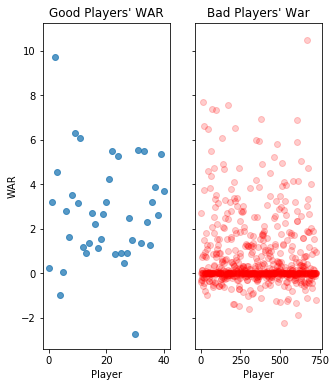

In [14]:
fig,ax = plt.subplots(1,2,sharey=True,figsize=(5,6))

ax[0].set_title('Good Players\' WAR')
ax[0].set_ylabel('WAR')
ax[0].set_xlabel('Player')
ax[0].scatter(np.arange(goodPlayers.shape[0]),goodPlayers.WAR,alpha=.75)

ax[1].set_title('Bad Players\' War')
ax[1].set_xlabel('Player')
ax[1].scatter(np.arange(badPlayers.shape[0]),badPlayers.WAR,color='r',alpha=.2)
plt.show()

In [15]:
'''
Hypothesis testing - Difference of means of good players gp and bad players bp
H_0: mu_gp - mu_bp = 0
H_1: mu_gp - mu_gp != 0
'''
# significance level of 95%
alpha = 0.05
mu_gp = goodPlayers.WAR.mean()
mu_bp = badPlayers.WAR.mean()
std_gp = goodPlayers.WAR.std()
std_bp = badPlayers.WAR.std()

num = mu_gp - mu_bp
den = (std_gp**2 / goodPlayers.shape[0]) + (std_bp**2 / badPlayers.shape[0])
z = num / np.sqrt(den)

# two tail test pval = 2*phi(-|z|)
p = 2* stats.norm.cdf(-np.abs(z))

In [16]:
np.round(p,5) # oh shit, there is a significant difference!

0.0

In [17]:
print('Population Means:',mu_gp,mu_bp)
print('Population stds:',std_gp,std_bp)
print('P = ',p)

Population Means: 2.705853658536586 0.607064471879287
Population stds: 2.29205472841483 1.4808909730747826
P =  6.808708464548006e-09


In [18]:
'''
Exploratory:
Confirm results by reducing size of WAR dataset to have only those in BSC.
'''
# Reduce down to match individuals we have data on
WAR_reduced = WAR_2016.loc[WAR_2016.name_common.isin(BSC.Name)]
WAR_reduced.head()

,name_common,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,pitcher,G,PA,salary,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAR_rep,WAA,WAR
61,Fernando Abad,472551.0,abadfe01,2016,BOS,2,AL,Y,2,0.0,1250000.0,0.0,0.0,0.0,0.00,0.00,0.00
235,Jose Abreu,547989.0,abreujo02,2016,CHW,1,AL,N,159,695.0,13334000.0,1.9,6.9,-14.0,2.36,0.32,2.68
310,Dustin Ackley,554429.0,ackledu01,2016,NYY,1,AL,N,28,70.0,3200000.0,-5.0,-8.0,1.6,0.24,-0.53,-0.29
359,Cristhian Adames,542436.0,adamecr01,2016,COL,1,NL,N,121,256.0,509500.0,-10.9,-11.9,4.0,0.80,-1.21,-0.41
466,Matt Adams,571431.0,adamsma01,2016,STL,1,NL,N,118,327.0,1650000.0,-2.0,-3.0,-2.6,1.02,-0.29,0.73


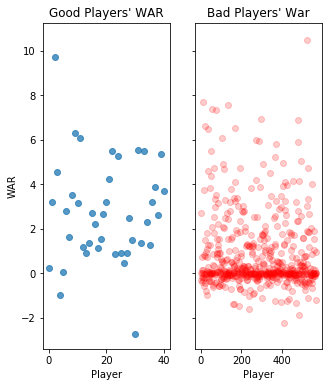

In [19]:
goodPlayers = WAR_reduced.loc[WAR_reduced.name_common.isin(BSC_filter.Name)]
badPlayers = WAR_reduced.loc[~WAR_reduced.name_common.isin(BSC_filter.Name)]

fig,ax = plt.subplots(1,2,sharey=True,figsize=(5,6))

ax[0].set_title('Good Players\' WAR')
ax[0].set_ylabel('WAR')
ax[0].set_xlabel('Player')
ax[0].scatter(np.arange(goodPlayers.shape[0]),goodPlayers.WAR,alpha=.75)

ax[1].set_title('Bad Players\' War')
ax[1].set_xlabel('Player')
ax[1].scatter(np.arange(badPlayers.shape[0]),badPlayers.WAR,color='r',alpha=.2)
plt.show()

In [20]:
'''
Hypothesis testing - Difference of means of good players gp and bad players bp
H_0: mu_gp - mu_bp = 0
H_1: mu_gp - mu_gp != 0
'''
# significance level of 95%
alpha = 0.05
mu_gp = goodPlayers.WAR.mean()
mu_bp = badPlayers.WAR.mean()
std_gp = goodPlayers.WAR.std()
std_bp = badPlayers.WAR.std()

num = mu_gp - mu_bp
den = (std_gp**2 / goodPlayers.shape[0]) + (std_bp**2 / badPlayers.shape[0])
z = num / np.sqrt(den)

# two tail test pval = 2*phi(-|z|)
p = 2* stats.norm.cdf(-np.abs(z))

In [21]:
print('Population Means:',mu_gp,mu_bp)
print('Population stds:',std_gp,std_bp)
print('P = ',p)

Population Means: 2.705853658536586 0.7732631578947373
Population stds: 2.29205472841483 1.6351738595674943
P =  1.1408511699663287e-07


### Results

In using Apriori to find frequent sets of common offensive batting stats, we are able to distinguish above average players from the population. Apriori reveals the most frequently occuring statistical ranges which most players fall in to which can be used as a filter for what the average player may look like. Removing those who posses average, frequent offensive stats, we are left with players who do not meet the norm. Whether this means we have the above average players or below average players is tested and confirmed through a standard Z test of the differences of mean WAR amongst the two populations.  

In [22]:
print('Good Players:',goodPlayers.shape[0])
print('Average Players:',badPlayers.shape[0])

Good Players: 41
Average Players: 570


In [23]:
print('Largest Frequent Itemset is length =',max(itemsets.keys()))

Largest Frequent Itemset is length = 8


In [24]:
print('Mean:')
print('Good:',mu_gp,'Bad:',mu_bp)
print('\nStandard Deviation')
print('Good:',std_gp,'Bad:',std_bp)
print('P = ',p,'=',np.round(p,6))

Mean:
Good: 2.705853658536586 Bad: 0.7732631578947373

Standard Deviation
Good: 2.29205472841483 Bad: 1.6351738595674943
P =  1.1408511699663287e-07 = 0.0


Based on the mean of both populations, the population of players that have been filtered out as good players are indeed better than those considered average. This is statistically significant with $\alpha = 0.05$.